# Modelado de un sistema con ipython

Para el correcto funcionamiento del extrusor de filamento, es necesario regular correctamente la temperatura a la que está el cañon. Por ello se usará un sistema consistente en una resitencia que disipe calor, y un sensor de temperatura PT100 para poder cerrar el lazo y controlar el sistema. A continuación, desarrollaremos el proceso utilizado.

In [2]:
#Importamos las librerías utilizadas
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
#Mostramos las versiones usadas de cada librerías
print ("Numpy v{}".format(np.__version__))
print ("Pandas v{}".format(pd.__version__))
print ("Seaborn v{}".format(sns.__version__))

Numpy v1.9.2
Pandas v0.16.2
Seaborn v0.6.0


In [4]:
#Mostramos todos los gráficos en el notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
#Abrimos el fichero csv con los datos de la muestra
datos = pd.read_csv('datos.csv')

In [6]:
#Almacenamos en una lista las columnas del fichero con las que vamos a trabajar
#columns = ['temperatura', 'entrada']
columns = ['temperatura', 'entrada']

## Respuesta del sistema

El primer paso será someter al sistema a un escalon en lazo abierto para ver la respuesta temporal del mismo. A medida que va calentando, registraremos los datos para posteriormente representarlos.

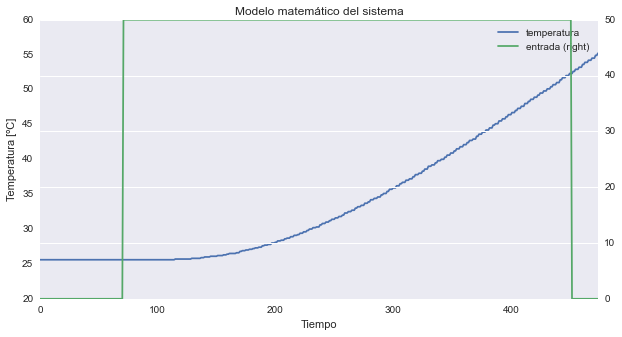

In [7]:
#Mostramos en varias gráficas la información obtenida tras el ensayo
ax = datos[columns].plot(secondary_y=['entrada'],figsize=(10,5), ylim=(20,60),title='Modelo matemático del sistema')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Temperatura [ºC]')
#datos_filtrados['RPM TRAC'].plot(secondary_y=True,style='g',figsize=(20,20)).set_ylabel=('RPM')


##Cálculo del polinomio

Hacemos una regresión con un polinomio de orden 2 para calcular cual es la mejor ecuación que se ajusta a la tendencia de nuestros datos.

In [8]:
# Buscamos el polinomio de orden 4 que determina la distribución de los datos
reg = np.polyfit(datos['time'],datos['temperatura'],2)
# Calculamos los valores de y con la regresión
ry = np.polyval(reg,datos['time'])
print (reg)

[  8.18174358e-09  -1.57332539e-04   2.59458703e+01]


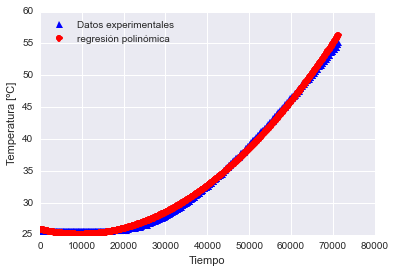

In [9]:
plt.plot(datos['time'],datos['temperatura'],'b^', label=('Datos experimentales'))
plt.plot(datos['time'],ry,'ro', label=('regresión polinómica'))
plt.legend(loc=0)
plt.grid(True)
plt.xlabel('Tiempo')
plt.ylabel('Temperatura [ºC]')


El polinomio caracteristico de nuestro sistema es:

$$P_x=  25.9459 -1.5733·10^{-4}·X - 8.18174·10^{-9}·X^2$$

##Transformada de laplace

Si calculamos la transformada de laplace del sistema, obtenemos el siguiente resultado:

$$G_s = \frac{25.95·S^2 - 0.00015733·S + 1.63635·10^{-8}}{S^3}$$

## Cálculo del PID mediante OCTAVE

Aplicando el método de sintonizacion de Ziegler-Nichols calcularemos el PID para poder regular correctamente el sistema.Este método, nos da d emanera rápida unos valores de $K_p$, $K_i$ y $K_d$ orientativos, para que podamos ajustar correctamente el controlador. Esté método consiste en el cálculo de tres parámetros característicos, con los cuales calcularemos el regulador:

$$G_s=K_p(1+\frac{1}{T_i·S}+T_d·S)=K_p+\frac{K_i}{S}+K_d$$


El cálculo de los parámetros característicos del método, lo realizaremos con Octave, con el siguiente código:
~~~
pkg load control
%los datos en la función tf() debe ser el numerador y denominador de nuestro sistema.
H=tf([25.95 0.000157333 1.63635E-8],[1 0 0 0]);
step(H);
dt=0.150;
t=0:dt:65;
y=step(H,t);
dy=diff(y)/dt;
[m,p]=max(dy);
yi=y(p);
ti=t(p);
L=ti-yi/m
Tao=(y(end)-yi)/m+ti-L
Kp=1.2*Tao/L
Ti=2*L;
Td=0.5*L;
Ki=Kp/ti;
Kd=Kp*Td;
~~~

En esta primera iteración, los datos obtenidos son los siguientes:
$K_p = 6082.6$ $K_i=93.868 K_d=38.9262$

Con lo que nuestro regulador tiene la siguiente ecuación característica:

$$G_s = \frac{38.9262·S^2 + 6082.6·S + 93.868}{S}$$

### Iteracción 1 de regulador

In [10]:
#Almacenamos en una lista las columnas del fichero con las que vamos a trabajar
datos_it1 = pd.read_csv('Regulador1.csv')
columns = ['temperatura']

 87.20
El valor de sobreoscilación es de: 9.00%
El valor del error en régimen permanente es de: 3.70


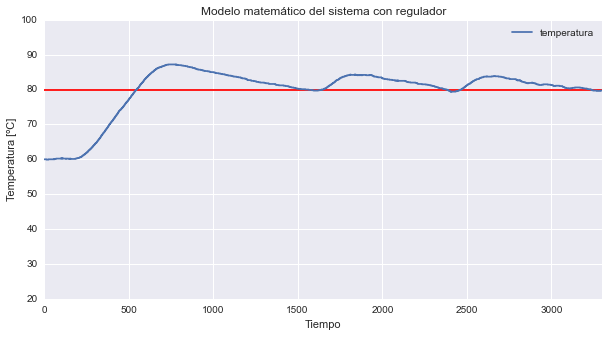

In [14]:
#Mostramos en varias gráficas la información obtenida tras el ensayo
ax = datos_it1[columns].plot(figsize=(10,5), ylim=(20,100),title='Modelo matemático del sistema con regulador',)
ax.set_xlabel('Tiempo')
ax.set_ylabel('Temperatura [ºC]')
ax.hlines([80],0,3500,colors='r')
#Calculamos MP
Tmax = datos_it1.describe().loc['max','temperatura'] #Valor de la Temperatura maxima en el ensayo

Sp=80.0 #Valor del setpoint
Mp= ((Tmax-Sp)/(Sp))*100
print("El valor de sobreoscilación es de: {:.2f}%".format(Mp))
#Calculamos el Error en régimen permanente
Errp = datos_it1.describe().loc['75%','temperatura'] #Valor de la temperatura en régimen permanente
Eregimen = abs(Sp-Errp)
print("El valor del error en régimen permanente es de: {:.2f}".format(Eregimen))

En este caso hemos establecido un setpoint de 80ºC Como vemos, una vez introducido el controlador, la temperatura tiende a estabilizarse, sin embargo tiene mucha sobreoscilación. Por ello aumentaremos los valores de $K_i$ y $K_d$, siendo los valores de esta segunda iteracción los siguientes:
$K_p = 6082.6$ $K_i=103.25 K_d=51.425$

### Iteracción 2 del regulador

In [16]:
#Almacenamos en una lista las columnas del fichero con las que vamos a trabajar
datos_it2 = pd.read_csv('Regulador2.csv')
columns = ['temperatura']

 86.70
El valor de sobreoscilación es de: 8.38%
El valor del error en régimen permanente es de: 3.50


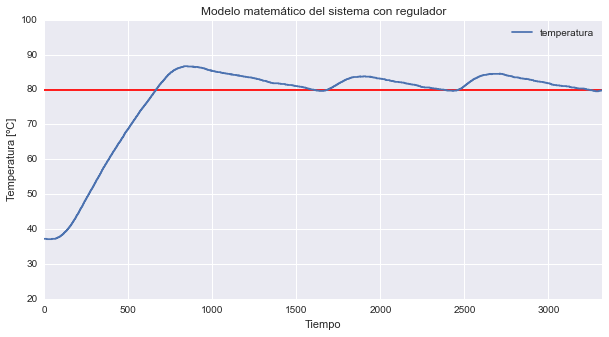

In [17]:
#Mostramos en varias gráficas la información obtenida tras el ensayo
ax2 = datos_it2[columns].plot(figsize=(10,5), ylim=(20,100),title='Modelo matemático del sistema con regulador',)
ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Temperatura [ºC]')
ax2.hlines([80],0,3500,colors='r')
#Calculamos MP
Tmax = datos_it2.describe().loc['max','temperatura'] #Valor de la Temperatura maxima en el ensayo

Sp=80.0 #Valor del setpoint
Mp= ((Tmax-Sp)/(Sp))*100
print("El valor de sobreoscilación es de: {:.2f}%".format(Mp))
#Calculamos el Error en régimen permanente
Errp = datos_it2.describe().loc['75%','temperatura'] #Valor de la temperatura en régimen permanente
Eregimen = abs(Sp-Errp)
print("El valor del error en régimen permanente es de: {:.2f}".format(Eregimen))

En esta segunda iteracción hemos logrado bajar la sobreoscilación inicial, pero tenemos mayor error en regimen permanente. Por ello volvemos a aumentar los valores de $K_i$ y $K_d$ siendo los valores de esta tercera iteracción los siguientes:
$K_p = 6082.6$ $K_i=121.64 K_d=60$

###Iteracción 3 del regulador

In [18]:
#Almacenamos en una lista las columnas del fichero con las que vamos a trabajar
datos_it3 = pd.read_csv('Regulador3.csv')
columns = ['temperatura']

 163.00
El valor de sobreoscilación es de: 1.88%
El valor del error en régimen permanente es de: 1.30


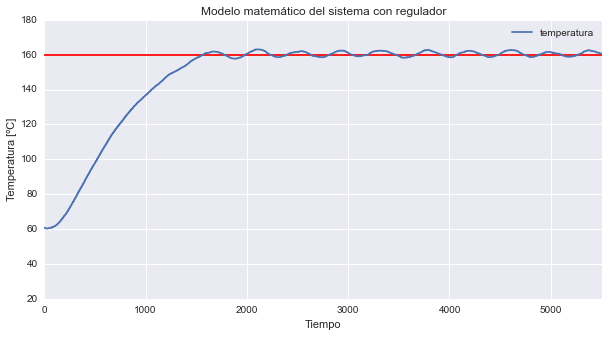

In [19]:
#Mostramos en varias gráficas la información obtenida tras el ensayo
ax3 = datos_it3[columns].plot(figsize=(10,5), ylim=(20,180),title='Modelo matemático del sistema con regulador',)
ax3.set_xlabel('Tiempo')
ax3.set_ylabel('Temperatura [ºC]')
ax3.hlines([160],0,6000,colors='r')
#Calculamos MP
Tmax = datos_it3.describe().loc['max','temperatura'] #Valor de la Temperatura maxima en el ensayo

Sp=160.0 #Valor del setpoint
Mp= ((Tmax-Sp)/(Sp))*100
print("El valor de sobreoscilación es de: {:.2f}%".format(Mp))
#Calculamos el Error en régimen permanente
Errp = datos_it3.describe().loc['75%','temperatura'] #Valor de la temperatura en régimen permanente
Eregimen = abs(Sp-Errp)
print("El valor del error en régimen permanente es de: {:.2f}".format(Eregimen))

En este caso, se puso un setpoint de 160ºC. Como vemos, la sobreoscilación inicial ha disminuido en comparación con la anterior iteracción y el error en regimen permanente es menor. Para intentar minimar el error, aumentaremos únicamente el valor de $K_i$. Siendo los valores de esta cuarta iteracción del regulador los siguientes:
    $K_p = 6082.6$ $K_i=121.64 K_d=150$

###Iteracción 4

In [21]:
#Almacenamos en una lista las columnas del fichero con las que vamos a trabajar
datos_it4 = pd.read_csv('Regulador4.csv')
columns = ['temperatura']

 163.00
El valor de sobreoscilación es de: 1.88%
El valor del error en régimen permanente es de: 1.10


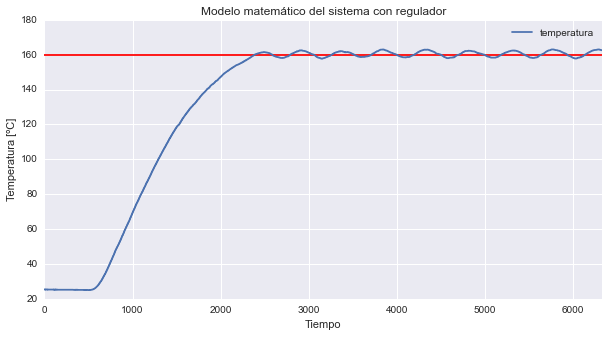

In [22]:
#Mostramos en varias gráficas la información obtenida tras el ensayo
ax4 = datos_it4[columns].plot(figsize=(10,5), ylim=(20,180),title='Modelo matemático del sistema con regulador',)
ax4.set_xlabel('Tiempo')
ax4.set_ylabel('Temperatura [ºC]')
ax4.hlines([160],0,7000,colors='r')
#Calculamos MP
Tmax = datos_it4.describe().loc['max','temperatura'] #Valor de la Temperatura maxima en el ensayo
print (" {:.2f}".format(Tmax))
Sp=160.0 #Valor del setpoint
Mp= ((Tmax-Sp)/(Sp))*100
print("El valor de sobreoscilación es de: {:.2f}%".format(Mp))
#Calculamos el Error en régimen permanente
Errp = datos_it4.describe().loc['75%','temperatura'] #Valor de la temperatura en régimen permanente
Eregimen = abs(Sp-Errp)
print("El valor del error en régimen permanente es de: {:.2f}".format(Eregimen))

Por lo tanto, el regulador que cumple con las especificaciones deseadas tiene la siguiente ecuación característica:
$$G_s = \frac{150·S^2 + 6082.6·S + 121.64}{S}$$